In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

import CarDetectorFunc as cd

In [2]:
config = cd.Config()
config.use_svd = False
config.show()

color space   : YCrCb
--- spatial-bining-color ---
use svd       : False
svd K         : 75
spatial size  : (32, 32)
--- color-histogram ----
hist bins     : 64
hist range    : (0, 256)
--- HOG ---
orient        : 7
pix per cell  : 8
cell per block: 2
hog channel   : ALL
--- Car Detection ---
ROI ystart    : 400
ROI ystop     : 700
window scale  : [1, 1.5, 2, 2.5]


## Load Data

In [3]:
# images are divided up into vehicles and non-vehicles
import fnmatch
import os

images = []
# for root, dirnames, filenames in os.walk('../dataset-big'):
#     for filename in fnmatch.filter(filenames, '*.png'):
for root, dirnames, filenames in os.walk('../dataset-small'):
    for filename in fnmatch.filter(filenames, '*.jpeg'):
        images.append(os.path.join(root, filename))
# images

cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
# cars

In [4]:
cd.print_data_info(car_list=cars, notcar_list=notcars)

cars: 1196, non-cars: 1125, total: 2321
image shape: (64, 64, 3), data type: uint8


## Get Features

In [5]:
if config.use_svd:
    svd_subspace = cd.get_main_feature_vectors(cars, config)
else:
    svd_subspace = None

In [6]:
%%time
car_features = cd.extract_features(cars, config, svd_subspace)
notcar_features = cd.extract_features(notcars, config, svd_subspace)

spatial_features.shape: (3072,)
hist_features.shape: (192,)
hog_features.shape: (4116,)
spatial_features.shape: (3072,)
hist_features.shape: (192,)
hog_features.shape: (4116,)
CPU times: user 9.13 s, sys: 140 ms, total: 9.27 s
Wall time: 9.35 s


## Classifier

### Tidy and Normalize

In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('X.shape: {}'.format(X.shape))
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('y.shape: {}'.format(y.shape))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

X.shape: (2321, 7380)
y.shape: (2321,)


### Explore features

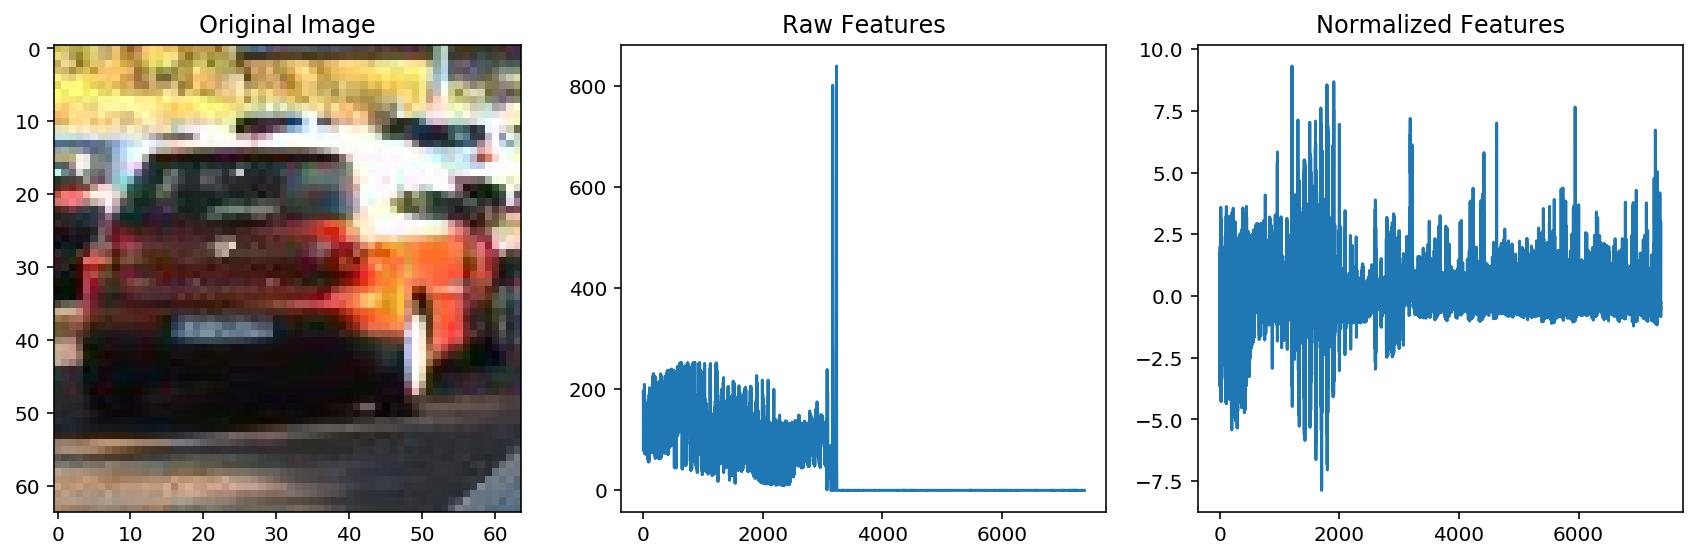

In [8]:
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Training

In [9]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
# it will also do shuffle
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)
print('X_train.shape: {}'.format(X_train.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('X_test.shape : {}'.format(X_test.shape))
print('y_test.shape : {}'.format(y_test.shape))

X_train.shape: (1624, 7380)
y_train.shape: (1624,)
X_test.shape : (697, 7380)
y_test.shape : (697,)


In [18]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('{:.4f} seconds to train SVC....'.format(t2-t))
# Check the score of the SVC
print('Train Accuracy of SVC = {:.4f}'.format(svc.score(X_train, y_train)))
print('Test Accuracy of SVC = {:.4f}'.format(svc.score(X_test, y_test)))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0:10,])
t2 = time.time()
print('{:.4f} seconds to predict with SVC'.format(t2-t))
print('prediction  : {}'.format(prediction))
print('ground truth: {}'.format(y_test[0:10]))

0.4916 seconds to train SVC....
Train Accuracy of SVC = 1.0000
Test Accuracy of SVC = 0.9928
0.0004 seconds to predict with SVC
prediction  : [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
ground truth: [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]


### Save Model and Config

In [19]:
svm_model = {}
svm_model['hyperconfig'] = config
svm_model['svc'] = svc
svm_model['X_scaler'] = X_scaler
svm_model

{'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'hyperconfig': <CarDetectorFunc.Config at 0x11b26f1d0>,
 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)}

In [24]:
import cPickle
cPickle.dump(svm_model, open('model/0330_svm_model.p', 'wb'))

In [30]:
loaded_model = cPickle.load(open('model/0330_svm_model.p', 'rb'))
loaded_model

{'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'hyperconfig': <CarDetectorFunc.Config at 0x11b46a0d0>,
 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)}